In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using StatsBase, Distributions, Plots, LinearAlgebra, Plots

In [3]:
using Revise

includet("../src/ESGModels/msvar.jl")
includet("../src/ESGModels/msvar_gibs.jl")
includet("../src/ESGModels/msvar_simulate.jl") 

In [4]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [-.02 .4 .25; .045 .15 .43]
Σ2 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2]
Σ = [Σ1, Σ2]

transition_matrix = [.98 .02;.05 .95]

states_zero = [.3, .7]
X = [.12, .06]



n_steps = 500
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

500×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0649932    0.0824744
 -0.184169     0.0400155
  0.0983932    0.0230791
 -0.212106     0.0859934
  0.0534826    0.0442884
  0.096443     0.00980478
  0.161573     0.0609192
  0.222373     0.141722
 -0.0138033    0.0506826
 -0.233419     0.0659138
  ⋮           
 -0.05712      0.145177
 -0.146722     0.0398168
  0.209387     0.0436455
 -0.00186754   0.0741823
 -0.227712     0.022684
 -0.15749     -0.0121551
  0.0603106   -0.0712535
 -0.0620107   -0.0376393
  0.0456804    0.023144

In [5]:
regime_count = count_regime_transitions(test_regimes, 2) 
regime_count ./ sum(regime_count, dims=2)

2×2 Matrix{Float64}:
 0.981424   0.0185759
 0.0340909  0.965909

In [6]:
display(count(x -> x==1, test_regimes))
unconditional_regimes(transition_matrix)

323

2-element Vector{Float64}:
 0.7142857142857144
 0.2857142857142857

In [7]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2
Β = [Β1, Β2]
Σ = [Σ1, Σ2]

2-element Vector{Matrix{Float64}}:
 [0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009]
 [0.0324 0.002205; 0.002205 0.0012250000000000002]

In [8]:
r = 1
display("regime count")
display(count(x -> x==r, test_regimes)/n_steps)

Ym = filter_X(Y, test_regimes[2:end], r)
Xm = filter_X(X, test_regimes[2:end], r)
Beta_mean = inv(Xm' * Xm) * Xm' * Ym
display(Beta_mean') 

display("true beta")
display(Β[r])

"regime count"

0.646

2×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0954987  0.258586  0.251812
 0.0276265  0.103994  0.626846

"true beta"

2×3 Matrix{Float64}:
 0.09  0.3  0.2
 0.03  0.1  0.6

In [9]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)
t_m = zeros(n, 2, 2)

states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
t_m[1, :, :] = sample_transition_matrix(states[1, :], k)

for s in 2:n
    states_zero = unconditional_regimes(t_m[s-1, :, :])
    states[s, :] = simulate_regimes(Y, X, Β, Σ, t_m[s-1, :, :], states_zero)
    t_m[s, :, :] = sample_transition_matrix(states[s, :], k)    
end 

r1 = [count(x -> x ==1, states[:,t]) for t in 1:n_steps-1] / n
display(r1)
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

499-element Vector{Float64}:
 0.0014
 0.0042
 0.0002
 0.0916
 0.1164
 0.1072
 0.0582
 0.0106
 0.0002
 0.0262
 ⋮
 0.0002
 0.0
 0.0008
 0.0012
 0.0002
 0.0894
 0.431
 0.4868
 0.5158

"transition matrix"

2×2 Matrix{Float64}:
 0.980358   0.0196423
 0.0376065  0.962394

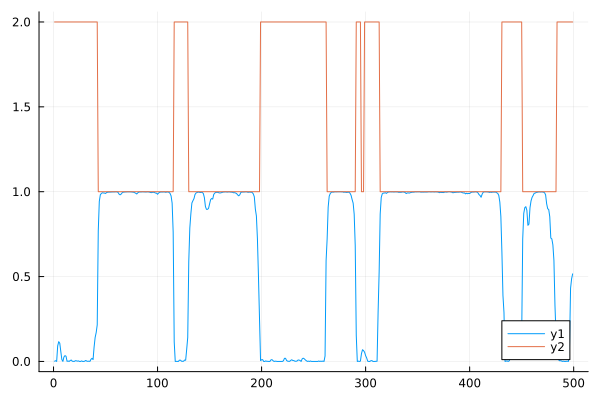

In [10]:
plot(r1)
plot!(test_regimes[2:end])

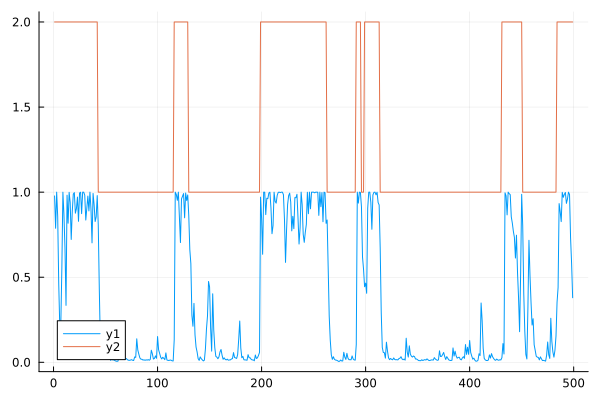

In [11]:
states_zero = [.6, .4]
regimes_probs = hamilton_filter(Y,X, Β, Σ, transition_matrix, states_zero)

plot(regimes_probs[:,2])
plot!(test_regimes[2:end])

In [12]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)


states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
cov_sample = [sample_covariance(Y, X, Β, states[1,:], k)] 

for s in 2:n
    states_zero = unconditional_regimes(transition_matrix)
    states[s, :] = simulate_regimes(Y, X, Β, Σ, transition_matrix, states_zero)
    push!(cov_sample, sample_covariance(Y, X, Β, states[s,:], k))    
end 

cov1_mean = mean(map(x -> x[1], cov_sample))
cov2_mean = mean(map(x -> x[2], cov_sample))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.07901735757956209
 0.031031059622234555

"regime two"

2-element Vector{Float64}:
 0.17044528237011936
 0.03552282849690444

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.315131
 0.315131  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0      0.39596
 0.39596  1.0

In [13]:
n_burn = 20_000
n_sample = 2000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, transition_matrix, [Β0', Β0'], [Σ0, Σ0], n_burn, n_sample)

([2 2 … 2 2; 2 2 … 2 2; … ; 2 2 … 2 2; 2 2 … 2 2], [0.9820048456255644 0.024586919009023257; 0.9870280987006551 0.02753988569756677; … ; 0.9827423950586781 0.04654794359318132; 0.9708036732025317 0.04923371432661749;;; 0.017995154374435628 0.9754130809909767; 0.012971901299344871 0.9724601143024333; … ; 0.017257604941321905 0.9534520564068188; 0.029196326797468232 0.9507662856733826], Vector{Any}[[[0.079213446725859 0.3102057227946232 0.2783886073046865; 0.01627747204588337 0.17619301094327708 0.5916597785334022], [-0.008888790070610511 0.38458095274535864 -0.16203144923151974; 0.03591662407956423 0.13231807273573062 0.5142492950224746]], [[0.11064435924566132 0.2811308518213371 0.13142269688002617; 0.02948971204904222 0.1667408216144402 0.5202458605493565], [-0.015603120888884943 0.43772438836218297 -0.20398479968214986; 0.036974934950151514 0.1238783659967865 0.4461404061172755]], [[0.09712390217833686 0.337713053621276 0.10192787756655947; 0.023976624080238675 0.13278946909183748 0.

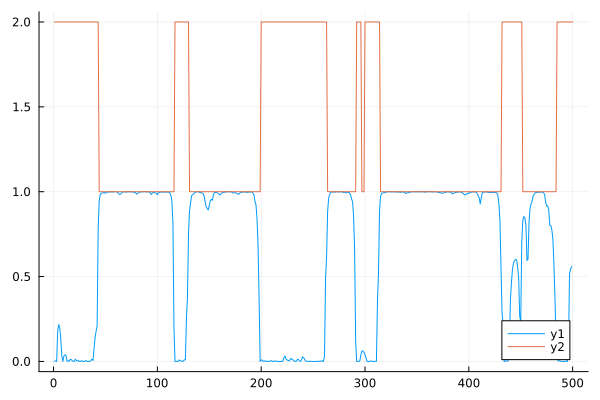

In [14]:
r1 = [count(x -> x ==1, regimes[:,t]) for t in 1:n_steps-1] / n_sample

plot(r1)
plot!(test_regimes)

In [15]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"transition matrix"

2×2 Matrix{Float64}:
 0.978505   0.021495
 0.0427232  0.957277

"coefficients"

"regime one"

2×3 Matrix{Float64}:
 0.0912556  0.263986  0.27388
 0.025324   0.123483  0.617124

"regime two"

2×3 Matrix{Float64}:
 -0.0249853  0.350604  0.0535434
  0.0401633  0.138036  0.463078

"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.07978339771886696
 0.03119369134831728

"regime two"

2-element Vector{Float64}:
 0.1693407397189414
 0.03565645582577374

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.320839
 0.320839  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.394804
 0.394804  1.0

In [4]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [.05 .35 .29; .06 .12 .5]
Σ2 = cor2cov([1 .4; .4 1], [.1, .04])
Β3 = [-.02 .4 .25; .045 .15 .43]
Σ3 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2, Β3]
Σ = [Σ1, Σ2, Σ3]

transition_matrix = [.90 .07 .03;.05 .85 .1;.13 .07 .80;]

states_zero = [.3, .1, .6]
X = [.12, .06]

n_steps = 1000
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

1000×2 adjoint(::Matrix{Float64}) with eltype Float64:
  0.284209   0.140322
 -0.104508   0.150991
 -0.232425   0.031875
  0.104385   0.0567862
  0.198996   0.0603077
  0.167783   0.0322728
  0.166223   0.109484
  0.0801175  0.12372
  0.0941776  0.146347
  0.0492537  0.127272
  ⋮          
  0.343511   0.243803
  0.382427   0.292484
  0.259766   0.222688
  0.088642   0.150547
  0.110157   0.121379
  0.149182   0.155202
  0.130089   0.127979
  0.0237525  0.154462
  0.241115   0.156104

In [7]:
count(x -> x==3, test_regimes)

255

In [8]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 3 #n_regimes
n_variables = 2


2

In [9]:
n_burn = 20_000
n_sample = 2000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)
t_m0 = [.9 .05 .05; .05 .9 .05; .05 .05 .9]

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, t_m0, [Β0', Β0', Β0'], [Σ0, Σ0, Σ0], n_burn, n_sample)

([2 2 … 1 1; 2 2 … 1 1; … ; 2 2 … 2 2; 2 2 … 1 1], [0.9159297437194894 0.08433654442616559 2.9812011632121246e-308; 0.9189492511050263 0.10784111180250844 0.0; … ; 0.9249437246167811 0.11198224524794802 9.693039431569597e-136; 0.9289126604349099 0.0962285169050266 0.0;;; 0.07505589989350209 0.9156634555738343 1.0; 0.07163522151611987 0.8921588881974917 1.0; … ; 0.06636396552910948 0.888017754752052 1.0; 0.057993777112741035 0.9037714830949735 1.0;;; 0.009014356387008647 0.0 0.0; 0.009415527378853927 3.3264274700371186e-76 1.586e-321; … ; 0.00869230985410934 0.0 4.083176144009262e-21; 0.013093562452348922 0.0 0.0], Vector{Any}[[[0.13441679539037363 0.3406778746638798 -0.24646180250764904; 0.04588739964611341 0.08961407682575907 0.5090081492834974], [-0.010748963666794448 0.5072741774517621 0.4264295031048326; 0.04358204603571061 0.1693546889538859 0.5090191364280273], [0.1400001122168281 16.64235851165145 -25.700372063685172; -0.035224538863903636 3.7255179268478695 -3.957957171493966]]

In [27]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))
display("regime three")
display(mean(map(x -> x[3],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))
cov3_mean = mean(map(x -> x[3], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))
display("regime three")
display(sqrt.(diag(cov3_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))
display("regime three")
display(cov2cor(cov3_mean))

"transition matrix"

3×3 Matrix{Float64}:
 0.663063   0.336932     4.68917e-6
 0.0898275  0.902106     0.00806698
 0.999638   0.000221202  0.000140507

"coefficients"

"regime one"

2×3 Matrix{Float64}:
 -0.0255562  0.441732  0.0883829
  0.0577329  0.16418   0.369705

"regime two"

2×3 Matrix{Float64}:
 0.0829076  0.305438   0.150376
 0.0345381  0.0743531  0.6225

"regime three"

2×3 Matrix{Float64}:
 -2.11433   -3.19807   23.3914
 -0.239266  -0.407745   3.24391

"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.17154309291250863
 0.03689677655565929

"regime two"

2-element Vector{Float64}:
 0.08510116289522719
 0.03233962870681222

"regime three"

2-element Vector{Float64}:
 4.437904607229927
 1.038996782237481

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.492158
 0.492158  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.300699
 0.300699  1.0

"regime three"

2×2 Matrix{Float64}:
 1.0      0.87669
 0.87669  1.0

In [23]:
using Test
regimes = [1 2 2 1 1 2 1]
n_regimes = 2
n_variables = 2 
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == true

regimes = [1 1 1 1 1 1 2]
n_regimes = 2
n_variables = 2 
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == false

regimes = [1 2 2 3 3 1 3]
n_regimes = 3
n_variables = 1
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == true

regimes = [1 2 2 1 1]
n_regimes = 3
n_variables = 1
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == false 

regimes = [1 2 2 3 3 1 3]
n_regimes = 3
n_variables = 2
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == false

Test Failed at c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:6
  Expression: result == true
   Evaluated: false == true



Test.FallbackTestSetException: Test.FallbackTestSetException("There was an error during testing")

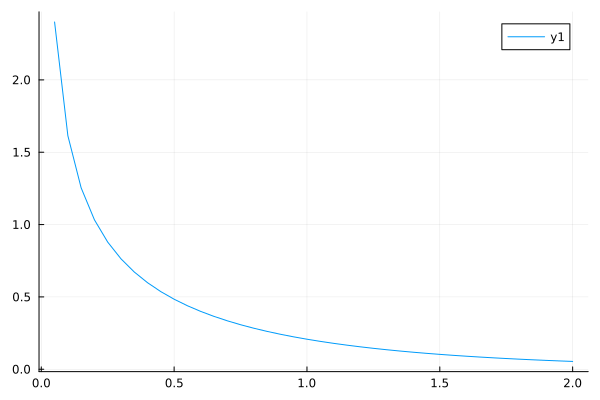

In [21]:
x = .05:.05:2
dist = [pdf(Gamma(0.5,1), r) for r in x]

plot(x, dist)